# faceRec

This IPython notebook will classify the emotion of a face

# Install packages

```
sudo apt-get install libopencv-dev python-opencv
sudo apt-get install -y python-qt4
sudo apt-get install python-matplotlib
sudo apt-get install python-dill
sudo pip install -U scikit-learn
sudo apt-get install nginx
sudo apt-get install gunicorn
```

# Details on face database
Cohn-Kanade AU-Coded Expression Database - CK+
University of Pittsburgh, Pittsburgh, PA

Lucey, P., Cohn, J. F., Kanade, T., Saragih, J., Ambadar, Z., & Matthews, I. (2010, June). The extended cohn-kanade dataset (ck+): A complete dataset for action unit and emotion-specified expression. In Computer Vision and Pattern Recognition Workshops (CVPRW), 2010 IEEE Computer Society Conference on (pp. 94-101). IEEE.
 
123 subjects (85 female)

FACS - Facial Action Coding System, extracts the geometrical features of the faces. Features are coded as action units (AU)

To label an expression with one of the values below, it must contain the set of AUs associated with that emotion (see table 2 in paper)

0=neutral, 1=anger, 2=contempt, 3=disgust, 4=fear, 5=happy, 6=sadness, 7=surprise

# Find the faces and emotion files

In [2]:
import glob
import os
from os.path import expanduser
import numpy as np
import cv2
from time import time
import cPickle as pickle
import dill
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import neighbors, linear_model
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_recall_curve, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [136]:
# Define functions
def findFace(inDict):
    faceCascade = inDict['faceCascade']
    # Load the emotion image
    rawImg = cv2.imread(inDict['imFile'])
    
    # Reshape
    if inDict['reshape']:
        # Resize just the face
        rawImg = cv2.resize(rawImg,(inDict['outImgSize'], inDict['outImgSize']), interpolation=cv2.INTER_CUBIC)
 
    # Detect faces in the image
    faces = faceCascade.detectMultiScale(
        rawImg,
        scaleFactor=inDict['scaleSize'],
        minNeighbors=inDict['numNeighbors'],
        minSize=(inDict['faceSize'], inDict['faceSize']),
        flags = cv2.CASCADE_SCALE_IMAGE
    )
    return rawImg, faces

def face2vec(inDict):
    faces = inDict['faces']
    rawImg = inDict['rawImg']
    outImgSize = inDict['outImgSize']
    # Get the largest face
    i = np.where(faces[:, 2] == faces[:, 2].max())
    faces = faces[i, :]
    faces = faces[0, :]
    x, y, w, h = faces[0, :]
    
    # Convert to gray
    gImg = cv2.cvtColor(rawImg, cv2.COLOR_BGR2GRAY)
    
    # Rectangle on face
    cv2.rectangle(rawImg, (x, y), (x + w, y + h), (0, 255, 0), 4)

    # Resize just the face
    x,y,w,h = faces[0,:]
    faceImg = gImg[y:y+h,x:x+w]
    faceImg = cv2.resize(faceImg,(outImgSize,outImgSize),interpolation = cv2.INTER_CUBIC)
    
    # Show images
    if inDict['showImage']:
        cv2.imshow('Image',faceImg)
        cv2.waitKey(30)

    # Flatten
    l = faceImg.shape[0] * faceImg.shape[1]
    img = faceImg.reshape(1, l)
    
    return img,faceImg,rawImg

def savePlot(inDict):
    plt.close('all')
    imFiles = inDict['imFiles']
    faceCascade = inDict['faceCascade']
    emotionLabels = inDict['emotionLabels']
    pca = inDict['pca']
    clf = inDict['clf']
    saveName = inDict['saveName']
    allProbs = []
    # Plot
    fig = plt.figure(figsize=(9,3 * len(imFiles)),frameon=False);
    gs = gridspec.GridSpec(len(imFiles), 2, width_ratios=[1,2]) 
    ct = -1
    for i in range(len(imFiles)):
        # Load the image
        findDict = dict([
            ('imFile',imFiles[i]),
            ('scaleSize',1.05),
            ('numNeighbors',3),
            ('faceSize',10),
            ('outImgSize',50),
            ('reshape',0),
            ('faceCascade',faceCascade),
        ])
        rawImg,faces = findFace(findDict)

        # Pull out image for classification
        faceDict = dict([
            ('faces',faces),
            ('rawImg',rawImg),
            ('outImgSize',500),
            ('showImage',0),
        ])
        img,faceImg,rawImg = face2vec(faceDict)

        # Classify image
        testFace = np.asarray(img)
        X_test_pca = pca(testFace)
        probs = clf(X_test_pca)
        allProbs.append(probs[0])

        # Face image
        ct = ct + 1
        ax0 = plt.subplot(gs[ct])
        plt.imshow(cv2.cvtColor(rawImg, cv2.COLOR_BGR2RGB))
        #plt.xlabel(Y_pred,fontsize=12)
        plt.tick_params(
            axis='both', 
            left='off', 
            top='off', 
            right='off', 
            bottom='off', 
            labelleft='off', 
            labeltop='off', 
            labelright='off', 
            labelbottom='off')

        # Probability plot
        ct = ct + 1
        width = 1
        ax1 = plt.subplot(gs[ct])
        index = np.arange(len(emotionLabels))
        ax2 = plt.bar(index * width,probs[0],width)
        ax2[0].set_color('r')
        ax2[1].set_color('g')
        ax2[2].set_color('y')
        ax2[3].set_color('c')
        ax2[4].set_color('b')
        ax2[5].set_color('k')
        ax1.set_ylim([0, 1])
        plt.xticks(index+0.5, emotionLabels,fontsize=12)
        plt.ylabel('Probability',fontsize=12)
    plt.savefig(saveName)
    return allProbs
    
def saveMovieFrames(inDict):
    inMovie = inDict['inMovie']
    saveDir = inDict['saveDir']
    frameNames = []
    if not os.path.isdir(saveDir):
        os.makedirs(saveDir)
    
    cap = cv2.VideoCapture(inMovie)
    success,image = cap.read()
    count = 0
    while success:
        success,image = cap.read()
        if success:
            cv2.imwrite(saveDir + "frame%d.jpg" % count, image)     # save frame as JPEG file
            frameNames.append(saveDir + "frame%d.jpg" % count)
            count += 1
    cap.release()
    return frameNames

def saveOutPlot(inDict):
    colors = ['r','g','y','c','b','k']
    allProbs = np.asarray(inDict['allProbs'])
    emotionLabels = inDict['emotionLabels']
    outName = inDict['outName']
    
    plt.close('all')
    fig = plt.figure(figsize=(12,6),frameon=False);
    for i in range(allProbs.shape[1]):
        plt.plot(allProbs[:,i],colors[i]);

    # Adjust legend, axes
    plt.legend(emotionLabels)
    ax = plt.gca()
    ax.set_xlim([0, allProbs.shape[0] - 1])
    ax.set_ylim([0, 1])
    plt.xlabel('Frame Number',fontsize=12)
    plt.ylabel('Probability',fontsize=12)
    # save plot
    plt.savefig(outName)
    
def movingAverage(data, window_size):
    y = []
    window = np.ones(int(window_size))/float(window_size)
    for x in data.T:
        tmp = np.convolve(x, window, 'full')
        y.append(tmp[0:len(data)])
    return np.transpose(np.asarray(y))

In [4]:
# Set home direcory
home = expanduser("~")

# Save file
saveDir = home + '/InsightProject/websiteFiles/'
saveFile = home + '/InsightProject/websiteFiles/save.p'
saveMovie = home + '/InsightProject/websiteFiles/faceMovie.mp4'

emotions = ['neutral','anger','contempt','disgust','fear','happy','sadness','surprise']
emotionLabels = ['anger','disgust','happy','neutral','sadness','surprise']

# OpenCV face classifier
cascPath = home + '/anaconda2/pkgs/opencv-3.1.0-np111py27_1/share/OpenCV/haarcascades/haarcascade_frontalface_default.xml'
faceCascade = cv2.CascadeClassifier(cascPath)

# Face processing defaults
outImgSize = 500
scaleSize = 1.05
numNeighbors = 3
faceSize = 150
showImage = 0
reshape = 0

# Classifier
n_components = 50

### CK+ images

In [ ]:
# Set paths, variable values
dbDir = home + '/InsightProject/faceDatabases/CK+/'
emoDir = home + '/InsightProject/faceDatabases/CK+/Emotion/'
emoNums = [3,1,6,0,5,7]

print("Loading input images...")
t0 = time()

# Initialize variables
subjectNames = []
subjectFiles = []
subjectEmotions = []
subjectImages = []

for subDir in glob.glob(emoDir + 'S*/'):
    subject = os.path.basename(os.path.dirname(subDir))
    
    for faceDir in glob.glob(subDir + '*/'):
        dirNum = os.path.basename(os.path.dirname(faceDir))
        for thisFile in glob.glob(faceDir + '*.txt'):
            imDir = os.path.join(dbDir,subject,dirNum)
            fName = os.path.basename(thisFile[:-12])
            imFile = os.path.join(imDir,fName + '.png')
            
            # Get the emotion
            with open(thisFile) as f:
                for line in f:
                    line = map(float, line.split())
                    lineInt = int(line[0])
                    # ignore 'contempt' and 'fear'
                    if lineInt != 2 and lineInt !=4:
                        thisEmotion = emotions[lineInt]
            # Find the face
            inDict = dict([
                ('imFile',imFile),
                ('scaleSize',scaleSize),
                ('numNeighbors',numNeighbors),
                ('faceSize',faceSize),
                ('outImgSize',outImgSize),
                ('reshape',reshape),
                ('faceCascade',faceCascade),
            ])
            rawImg,faces = findFace(inDict)

            # If a face is detected
            if len(faces): 
                inDict = dict([
                    ('faces',faces),
                    ('rawImg',rawImg),
                    ('outImgSize',outImgSize),
                    ('showImage',showImage),
                    ])
                img = face2vec(inDict)
                
                # Append to subjectNames
                subjectNames.append(subject)
                # Append to subjectEmotions
                subjectEmotions.append(thisEmotion)
                # Append to subjectFiles
                subjectFiles.append(imFile) 
                # Append to output matrices
                subjectImages.append(img[0]) 
                
            # Load the neutral image
            imFile = os.path.join(imDir,fName[:-3] + '001.png')
            # Find the face
            inDict = dict([
                ('imFile',imFile),
                ('scaleSize',scaleSize),
                ('numNeighbors',numNeighbors),
                ('faceSize',faceSize),
                ('outImgSize',outImgSize),
                ('reshape',reshape),
                ('faceCascade',faceCascade),
            ])
            rawImg,faces = findFace(inDict)

            # If a face is detected
            if len(faces):
                inDict = dict([
                    ('faces',faces),
                    ('rawImg',rawImg),
                    ('outImgSize',outImgSize),
                    ('showImage',showImage),
                    ])
                img = face2vec(inDict)
                
                # Append to subjectNames
                subjectNames.append(subject)
                # Append to subjectEmotions
                subjectEmotions.append('neutral')
                # Append to subjectFiles
                subjectFiles.append(imFile) 
                # Append to output matrices
                subjectImages.append(img[0]) 
                
# Convert to numpy array    
subjectNames = np.asarray(subjectNames)
subjectEmotions = np.asarray(subjectEmotions)
subjectFiles = np.asarray(subjectFiles)
subjectImages = np.squeeze(np.asarray(subjectImages))

print("done in %0.3fs" % (time() - t0))

In [ ]:
cv2.destroyAllWindows()

### Pipes

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    subjectImages, subjectEmotions, test_size=0.2, random_state=42)

In [ ]:
# pca = PCA()
# logistic = linear_model.LogisticRegression()
# # Make the 'pipe'
# pcaPipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

In [ ]:
pca = PCA()
svm = SVC(class_weight='balanced',probability=True);
# Make the 'pipe'
svmPipe = Pipeline(steps=[('pca', pca), ('svm', svm)])

In [ ]:
# Plot the PCA spectrum
print("Finding the best parameters")
t0 = time()
pca.fit(subjectImages)
print("done in %0.3fs" % (time() - t0))

ax = plt.figure(1, figsize=(4, 3))
plt.clf()
#plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
#plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')
ax = plt.gca()
ax.set_xlim([0, 100])
plt.savefig('/Users/abock/Desktop/InsightProject/PCA_varExplained.jpg')

In [ ]:
# print("Finding the best logistic parameters")
# t0 = time()
# n_components = [50,75,100]
# C = [1e3, 5e3, 1e4, 5e4, 1e5]

# #Parameters of pipelines can be set using ‘__’ separated parameter names:

# clfPCA = GridSearchCV(pcaPipe,
#                          dict(pca__n_components=n_components,
#                               logistic__C=C))
# clfPCA.fit(X_train, Y_train)

# print("done in %0.3fs" % (time() - t0))

In [ ]:
# plt.axvline(clfPCA.best_estimator_.named_steps['pca'].n_components,
#             linestyle=':', label='n_components chosen')
# plt.legend(prop=dict(size=12))
# plt.show()

In [ ]:
# Y_pred = clfPCA.predict(X_test)
# print(classification_report(Y_test, Y_pred))

In [ ]:
print("Finding the best SVM parameters")
t0 = time()
#n_components = [50,75,100]
n_components = 50
C = [1e3, 5e3, 1e4, 5e4, 1e5]
gamma = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]

#Parameters of pipelines can be set using ‘__’ separated parameter names:

clfSVM = GridSearchCV(svmPipe,
                         dict(pca__n_components=n_components,
                              svm__C=C,svm__gamma=gamma))

clfSVM.fit(subjectImages, subjectEmotions)

print("done in %0.3fs" % (time() - t0))

In [ ]:
clfSVM.best_estimator_

In [ ]:
ax = plt.figure(1, figsize=(12, 6))
plt.clf()
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')
ax = plt.gca()
ax.set_xlim([0, 100])
plt.axvline(clfSVM.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()
#plt.savefig('/Users/abock/Desktop/InsightProject/PCA_varExplained-optimal.jpg')

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    subjectImages, subjectEmotions, test_size=0.2, random_state=42)

In [ ]:
Y_pred = clfSVM.predict(X_test)
print(classification_report(Y_test, Y_pred))

In [ ]:
for emotion in emotions:
    print(emotion)
    emotionSummary = np.array(subjectEmotions == emotion)
    print(np.sum(emotionSummary))

In [ ]:
# Save out the pca and classifier
print("Saving the training set to file")
t0 = time()
pickle.dump([pca,clf],open(saveFile,'w'))
print("done in %0.3fs" % (time() - t0))

# Train a model

### SVM

In [ ]:
X_train = subjectImages
Y_train = subjectEmotions

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
print("done in %0.3fs" % (time() - t0))

print("Fitting the classifier to the training set")
t0 = time()

# param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
#               'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}

# param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
#               'gamma': [0.001, 0.005, 0.01, 0.05, 0.1],
#              'kernel': ['linear','poly','rbf','sigmoid']}

param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1],
             'kernel': ['rbf']}

clf = GridSearchCV(SVC(class_weight='balanced',probability=True), param_grid)

# metrics = ['minkowski','euclidean','manhattan'] 
# weights = ['uniform','distance'] #10.0**np.arange(-5,4)
# NN = np.arange(1,30)
# #algorithms = ['ball_tree', 'kd_tree', 'brute']
# algorithms = ['brute']
# param_grid = dict(metric=metrics,weights=weights,n_neighbors=NN,algorithm=algorithms)
# clf = GridSearchCV(neighbors.KNeighborsClassifier(), param_grid)

clf = clf.fit(X_train_pca, Y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")

print(clf.best_estimator_)

In [ ]:
# Save out the pca and classifier
print("Saving the training set to file")
t0 = time()
pcaTransform = pca.transform
clfPredictProba = clf.predict_proba
dill.dump([pcaTransform,clfPredictProba],open(saveFile,'w'))
# pickle.dump([pcaTransform,clfPredictProba],open(saveFile,'w'))
print("done in %0.3fs" % (time() - t0))

In [ ]:
pca, clf = dill.load(open('/Users/abock/InsightProject/websiteFiles/save.p','rb'))

# Train / test

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    subjectImages, subjectEmotions, test_size=0.2, random_state=42)

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)

In [ ]:
X_train_pca.shape

In [ ]:
print("done in %0.3fs" % (time() - t0))

print("Fitting the classifier to the training set")
t0 = time()

# param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
#               'gamma': [0.001, 0.005, 0.01, 0.05, 0.1],
#              'kernel': ['linear','poly','rbf','sigmoid']}

# param_grid = {'C': [5e3],
#               'gamma': [0.01],
#              'kernel': ['rbf']}

# clf = GridSearchCV(SVC(class_weight='balanced',probability=True), param_grid)

clf = SVC(class_weight='balanced',probability=True,C=5000,gamma=0.01,kernel='rbf')


# metrics = ['minkowski','euclidean','manhattan'] 
# weights = ['uniform','distance'] #10.0**np.arange(-5,4)
# NN = np.arange(1,30)
# #algorithms = ['ball_tree', 'kd_tree', 'brute']
# algorithms = ['brute']
# param_grid = dict(metric=metrics,weights=weights,n_neighbors=NN,algorithm=algorithms)
# clf = GridSearchCV(neighbors.KNeighborsClassifier(), param_grid)

clf = clf.fit(X_train_pca, Y_train)
print("done in %0.3fs" % (time() - t0))
# print("Best estimator found by grid search:")
# print(clf.best_estimator_)

# Plot results
X_test_pca = pca.transform(X_test)
Y_pred = clf.predict(X_test_pca)
probs = clf.predict_proba(X_test_pca)
print(classification_report(Y_test, Y_pred))

print("Accuracy score:")
print(accuracy_score(Y_test, Y_pred))

In [ ]:
print("Recall score:")
print(recall_score(Y_test, Y_pred,average='weighted'))

In [ ]:
print("Precision score:")
print(precision_score(Y_test, Y_pred,average='weighted'))

In [ ]:
conf_arr = confusion_matrix(Y_test, Y_pred)

In [ ]:
norm_conf = []
for i in conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

fig = plt.figure(1,figsize=(8, 8))

plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in xrange(width):
    for y in xrange(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

plt.xticks(range(width), emotionLabels[:width])
plt.yticks(range(height), emotionLabels[:height])
plt.show()

In [ ]:
# Plot Recall vs Precision
outMat = precision_recall_fscore_support(Y_test, Y_pred,labels=emotionLabels)
precision = outMat[0]
recall = outMat[1]
plt.plot(recall,precision, 'ro')
plt.axis([0, 1, 0, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(probs.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(Y_test == emotionLabels[i],Y_pred == emotionLabels[i])
    roc_auc = auc(fpr[i],tpr[i])
    plt.plot(fpr[i],tpr[i],label=emotionLabels[i] + ' (AUC = %0.2f)' % roc_auc)
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Novel image

In [5]:
print("Loading the training set to file")
t0 = time()
pca, clf = pickle.load(open(saveFile,'rb'))
print("done in %0.3fs" % (time() - t0))

Loading the training set to file
done in 0.365s


In [ ]:
# Save figures
imFiles = ['/Users/abock/Desktop/InsightProject/imageFiles/sad-Keanu.png',
           '/Users/abock/Desktop/InsightProject/imageFiles/happy-guy.png',
           '/Users/abock/Desktop/InsightProject/imageFiles/angry-guy.jpg',
           '/Users/abock/Desktop/InsightProject/imageFiles/sadDawson.jpg',
           '/Users/abock/Desktop/InsightProject/websiteFiles/andrewBock/images/frame32.jpg',
           '/Users/abock/Desktop/InsightProject/websiteFiles/andrewBock/images/frame9.jpg',
          ]
inDict = dict([
    ('imFiles',imFiles),
    ('faceCascade',faceCascade),
    ('emotionLabels',emotionLabels),
    ('faceCascade',faceCascade),
    ('pca',pca),
    ('clf',clf),
    ('saveName',saveName),
])
savePlot(inDict)

In [ ]:
saveName

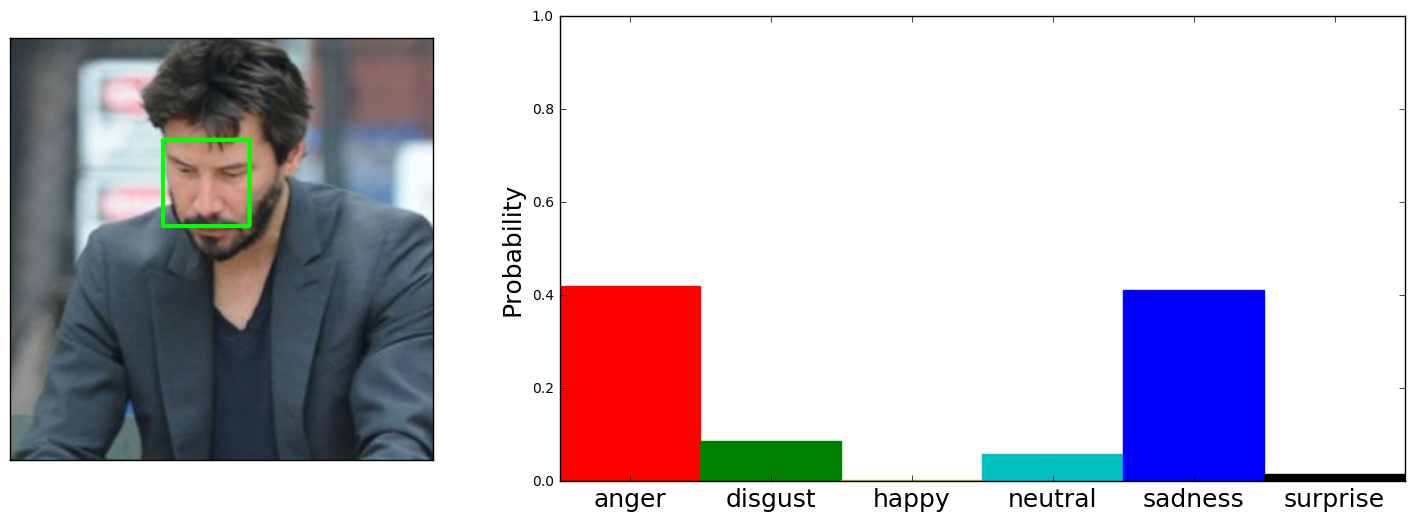

In [10]:
#imFile = '/Users/abock/Desktop/InsightProject/imageFiles/angry-guy.jpg'
imFile = '/Users/abock/InsightProject/imageFiles/01-sad-Keanu.png'
#imFile = '/Users/abock/Desktop/InsightProject/imageFiles/happy-guy.png'
#imFile = '/Users/abock/Desktop/InsightProject/imageFiles/sadDawson.jpg'

#imFile = '/Users/abock/Desktop/InsightProject/websiteFiles/andrewBock/images/frame1.jpg'

#imFile = '/Users/abock/Downloads/winonaRyder/frame590.jpg'

#imFile = '/Users/abock/Desktop/InsightProject/imageFiles/aia_sadness_547.png'
#imFile = '/Users/abock/Desktop/InsightProject/imageFiles/aia_anger_93.png'

cv2.destroyAllWindows()

cascPath = '/usr/local/Cellar/opencv/2.4.13.2/share/OpenCV/haarcascades/haarcascade_frontalface_default.xml'
faceCascade = cv2.CascadeClassifier(cascPath)

# Load the image
inDict = dict([
    ('imFile',imFile),
    ('scaleSize',1.05),
    ('numNeighbors',3),
    ('faceSize',10),
    ('outImgSize',500),
    ('reshape',0),
    ('faceCascade',faceCascade),
])
rawImg,faces = findFace(inDict)

# Pull out image for classification
inDict = dict([
    ('faces',faces),
    ('rawImg',rawImg),
    ('outImgSize',outImgSize),
    ('showImage',0),
])
img,faceImg,rawImg = face2vec(inDict)

# Classify image
testFace = np.asarray(img)
X_test_pca = pca(testFace)
probs = clf(X_test_pca)

# Plot
fig = plt.figure(figsize=(9,3));
gs = gridspec.GridSpec(1, 2, width_ratios=[1,2]);

# Face image 
ax0 = plt.subplot(gs[0])
plt.imshow(cv2.cvtColor(rawImg, cv2.COLOR_BGR2RGB))
#plt.xlabel(Y_pred,fontsize=12)
plt.tick_params(
    axis='both', 
    left='off', 
    top='off', 
    right='off', 
    bottom='off', 
    labelleft='off', 
    labeltop='off', 
    labelright='off', 
    labelbottom='off')

# Probability plot
width = 1
ax1 = plt.subplot(gs[1])
index = np.arange(len(emotionLabels))
ax2 = plt.bar(index * width,probs[0],width)
ax2[0].set_color('r')
ax2[1].set_color('g')
ax2[2].set_color('y')
ax2[3].set_color('c')
ax2[4].set_color('b')
ax2[5].set_color('k')
ax1.set_ylim([0, 1])
plt.xticks(index+0.5, emotionLabels,fontsize=12)
plt.ylabel('Probability',fontsize=12)

plt.show()

# Save movie output plot

In [26]:
# Get frame names
inDict = dict([
    ('inMovie','/Users/abock/InsightProject/websiteFiles/subject001/faceMovie.mp4'),
    ('saveDir','/Users/abock/InsightProject/websiteFiles/subject001/faceMovie/'),
])
frameNames = saveMovieFrames(inDict)

# Get probabilities, save output frames
saveName = '/Users/abock/InsightProject/websiteFiles/subject001/outFrames.jpg'
inDict = dict([
    ('imFiles',frameNames),
    ('faceCascade',faceCascade),
    ('emotionLabels',emotionLabels),
    ('saveName',saveName),
    ('pca',pca),
    ('clf',clf),
])
allProbs = savePlot(inDict)

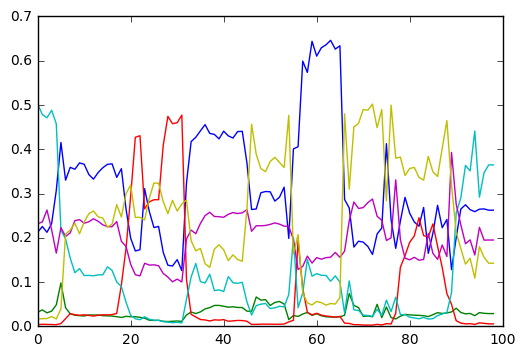

In [118]:
# Convert probs to percent signal change
foo = np.asarray(allProbs)
plt.plot(foo)
plt.show()

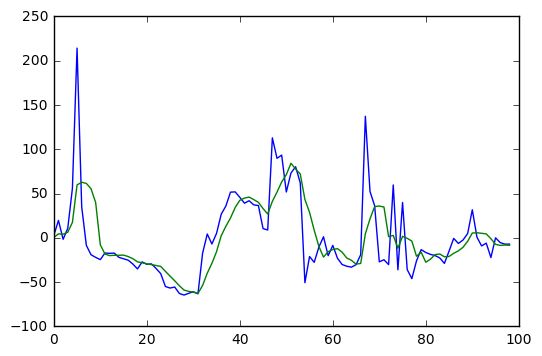

In [113]:
y = movingAverage(data,5)
plt.plot(data)
plt.plot(y)
plt.show()

In [236]:
def movingAverage(data, window_size):
    y = []
    window = np.ones(int(window_size))/float(window_size)
    for x in data.T:
        tmp = np.convolve(x, window, 'full')
        y.append(tmp[0:len(data)])
    return np.transpose(np.asarray(y))

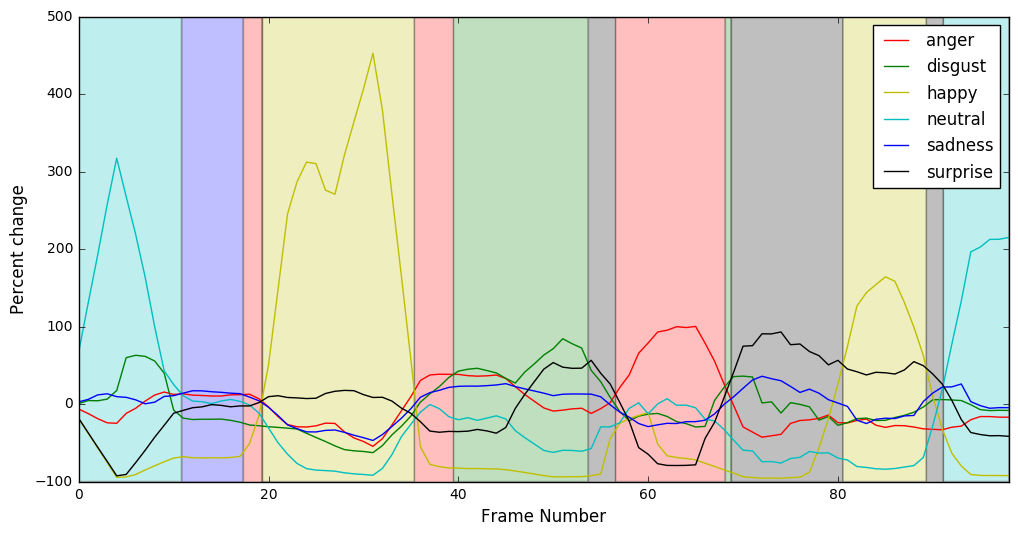

In [295]:
psc = ((allProbs / np.mean(allProbs,0)) - 1) * 100
psc = movingAverage(psc,5)
#plt.plot(psc)

colors = ['r','g','y','c','b','k']

plt.close('all')
fig = plt.figure(figsize=(12,6),frameon=False);
for i in range(psc.shape[1]):
    plt.plot(psc[:,i],colors[i]);

ax = plt.gca()
ymin, ymax = ax.get_ylim()
x = range(psc.shape[0])

x2 = np.linspace(x[0], x[-1], len(x) * 100)

ct = 0
foo = []
for i in psc.T:
    foo.append(np.interp(x2,x,psc[:,ct]))
    ct = ct + 1
foo = np.transpose(np.asarray(foo))

maxPSC = foo.max(1)

ax.fill_between(x2, ymin, ymax, where=foo[:,0] == maxPSC, alpha=0.25, facecolor=colors[0])
ax.fill_between(x2, ymin, ymax, where=foo[:,1] == maxPSC, alpha=0.25, facecolor=colors[1])
ax.fill_between(x2, ymin, ymax, where=foo[:,2] == maxPSC, alpha=0.25, facecolor=colors[2])
ax.fill_between(x2, ymin, ymax, where=foo[:,3] == maxPSC, alpha=0.25, facecolor=colors[3])
ax.fill_between(x2, ymin, ymax, where=foo[:,4] == maxPSC, alpha=0.25, facecolor=colors[4])
ax.fill_between(x2, ymin, ymax, where=foo[:,5] == maxPSC, alpha=0.25, facecolor=colors[5])

plt.legend(emotionLabels)

ax.set_xlim([0, psc.shape[0] - 1])
#ax.set_ylim([0, 1])
plt.xlabel('Frame Number',fontsize=12)
plt.ylabel('Percent change',fontsize=12)
plt.show()

In [27]:
# Save output plot
outName = '/Users/abock/InsightProject/websiteFiles/subject001/outPlot.jpg'
inDict = dict([
    ('allProbs',allProbs),
    ('emotionLabels',emotionLabels),
    ('outName',outName),
])
saveOutPlot(inDict)

# Save frames AND plot as movie - andrewBock

In [6]:
inDir = '/Users/abock/Desktop/InsightProject/websiteFiles/andrewBock/images/'
outDir = '/Users/abock/Desktop/InsightProject/websiteFiles/andrewBock/figures/'

for i in range(0,99):
    imFile = (inDir + "frame%d.jpg" % i)
    saveName = (outDir + "frame%d.jpg" % i)
    
    # Load the image
    inDict = dict([
        ('imFile',imFile),
        ('scaleSize',1.05),
        ('numNeighbors',3),
        ('faceSize',10),
        ('outImgSize',outImgSize),
        ('reshape',0),
        ('faceCascade',faceCascade),
    ])

    rawImg,faces = findFace(inDict)

    # Pull out image for classification
    inDict = dict([
        ('faces',faces),
        ('rawImg',rawImg),
        ('outImgSize',outImgSize),
        ('showImage',0),
    ])
    img,faceImg,rawImg = face2vec(inDict)
    
    
    testFace = np.asarray(img)
    X_test_pca = pca.transform(testFace)
    probs = clf.predict_proba(X_test_pca)
        
    inDict = dict([
        ('imFiles', imFiles),
        ('faceCascade', faceCascade),
        ('emotionLabels', emotionLabels),
        ('pca', pca),
        ('clf',clf),
        ('saveName', plotName),
        ])
    savePlot(inDict)
    plt.close('all')

TypeError: tuple indices must be integers, not tuple

# Record Movie

In [ ]:
import numpy as np
import cv2
import time
import os

outDir = '/Users/abock/Desktop/faceMovie/'
if not os.path.isdir(outDir):
    os.makedirs(outDir)

cap = cv2.VideoCapture(0)

# Define the codec and create VideoWriter object
cap = cv2.VideoCapture(0)
w = cap.get(cv2.CAP_PROP_FRAME_WIDTH);
h = cap.get(cv2.CAP_PROP_FRAME_HEIGHT); 
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(saveMovie,fourcc, 15.0, (int(w),int(h)))

time.sleep(5) # wait for camera to catch up
ct = 0
while ct < 100:
    ct = ct + 1
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    if ret==True:
        #frame = cv2.flip(frame,0)

        # write the flipped frame
        out.write(frame)

        cv2.imshow('frame',frame)
        cv2.waitKey(30)

# When everything done, release the capture
cap.release()
out.release()
cv2.destroyAllWindows()

# Save frames as movie

In [ ]:
fileNames = [
    '/Users/abock/Desktop/InsightProject/websiteFiles/frame10.jpg',
    '/Users/abock/Desktop/InsightProject/websiteFiles/frame11.jpg',
    '/Users/abock/Desktop/InsightProject/websiteFiles/frame12.jpg',
    '/Users/abock/Desktop/InsightProject/websiteFiles/frame13.jpg',
    '/Users/abock/Desktop/InsightProject/websiteFiles/frame14.jpg',
]

In [ ]:
import cv2
cap = cv2.VideoCapture(0)
w = cap.get(cv2.CAP_PROP_FRAME_WIDTH);
h = cap.get(cv2.CAP_PROP_FRAME_HEIGHT); 
cap.release()
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('foo.mp4',fourcc, 15.0, (int(w),int(h)))
for fileName in fileNames:
    foo = cv2.imread(fileName)
    out.write(foo)
    cv2.imshow('foo',foo)
    cv2.waitKey(30)

out.release()
cv2.destroyAllWindows()

In [ ]:
cv2.destroyAllWindows()

# Download images

In [ ]:
from bs4 import BeautifulSoup
import urllib2 
import urllib
import os

def saveURLimages(url,outDir):
    req = urllib2.Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    html = urllib2.urlopen(req).read()
    soup = BeautifulSoup(html)
    # get images
    images = [img for img in soup.findAll('img')]
    print (str(len(images)) + " images found.")
    print 'Downloading images to: ' + outDir
    
    # download images
    image_links = [each.get('src') for each in images]
    #print(image_links)
    for each in image_links:
        if not each is None:
            if each[0:4] == 'http':
                #print(each)
                filename=each.split('/')[-1]
                urllib.urlretrieve(each,os.path.join(outDir,filename + '.jpg'))

### Google

In [ ]:
# Save happy faces (Google Images)
happyPerson = 'https://www.google.com/search?site=&tbm=isch&source=hp&biw=1680&bih=949&q=happy+person&oq=happy+person&gs_l=img.3..0l10.15311.17067.0.17213.12.7.0.5.5.0.82.450.7.7.0....0...1ac.1.64.img..0.12.461.FpA8-IvoCOk'
url = happyPerson
outDir = '/Users/abock/Desktop/HappyFaces'
if not os.path.isdir(outDir):
    os.makedirs(outDir)
saveURLimages(url,outDir)

# Save sad faces (Google Images)
sadPerson = 'https://www.google.com/search?site=&tbm=isch&source=hp&biw=840&bih=949&q=sad+person&oq=sad+person&gs_l=img.3..0l10.732.2268.0.2413.10.7.0.3.3.0.337.1010.0j1j2j1.4.0....0...1ac.1.64.img..3.7.1015.rkrdqlI1p-k'
url = sadPerson
outDir = '/Users/abock/Desktop/SadFaces'
if not os.path.isdir(outDir):
    os.makedirs(outDir)
saveURLimages(url,outDir)

### Bing

In [ ]:
# Save happy faces (Bing Images)
happyPerson = 'https://www.bing.com/images/search?q=happy%20person&qs=n&form=QBIR&pq=happy%20person&sc=8-12&sp=-1&sk='
url = happyPerson
outDir = '/Users/abock/Desktop/HappyFaces'
if not os.path.isdir(outDir):
    os.makedirs(outDir)
saveURLimages(url,outDir)

# Save sad faces (Bing Images)
sadPerson = 'https://www.bing.com/images/search?q=sad+person&qs=n&form=QBILPG&pq=sad+person&sc=8-8&sp=-1&sk='
url = sadPerson
outDir = '/Users/abock/Desktop/SadFaces'
if not os.path.isdir(outDir):
    os.makedirs(outDir)
saveURLimages(url,outDir)

### Happy Faces

In [ ]:
# Save happy faces (Yahoo Images)
outDir = '/Users/abock/Desktop/HappyFaces'
if not os.path.isdir(outDir):
    os.makedirs(outDir)
    
happyPerson = 'https://images.search.yahoo.com/search/images;_ylt=AwrTcXdqJYFYvE0A0juLuLkF?p=happy+person&ei=UTF-8&iscqry=&fr=sfp'
url = happyPerson
saveURLimages(url,outDir)

happyHumanFace = 'https://images.search.yahoo.com/search/images;_ylt=AwrTcXyAJoFYWHMApB6JzbkF;_ylu=X3oDMTBsZ29xY3ZzBHNlYwNzZWFyY2gEc2xrA2J1dHRvbg--;_ylc=X1MDOTYwNjI4NTcEX3IDMgRhY3RuA2NsawRiY2sDNmltaTE4bGM2N29ybyUyNmIlM0QzJTI2cyUzRDI5BGNzcmNwdmlkAzNzeFdhVEl3Tmk1cFdrRkZXR1BqZUFkSE5qVXVPQUFBQUFDdHdqNncEZnIDc2ZwBGZyMgNzYS1ncARncHJpZANLQm5lbEt4X1JOeUlzNXY5WC40cVRBBG10ZXN0aWQDbnVsbARuX3N1Z2cDMTAEb3JpZ2luA2ltYWdlcy5zZWFyY2gueWFob28uY29tBHBvcwMwBHBxc3RyAwRwcXN0cmwDBHFzdHJsAzE2BHF1ZXJ5A2hhcHB5IGh1bWFuIGZhY2UEdF9zdG1wAzE0ODQ4NTkwNzYEdnRlc3RpZANudWxs?gprid=KBnelKx_RNyIs5v9X.4qTA&pvid=3sxWaTIwNi5pWkFFWGPjeAdHNjUuOAAAAACtwj6w&p=happy+human+face&fr=sfp&fr2=sb-top-images.search.yahoo.com&ei=UTF-8&n=60&x=wrt'
url = happyHumanFace
saveURLimages(url,outDir)



### Sad Faces

In [ ]:
# Output directory
outDir = '/Users/abock/Desktop/SadFaces'
if not os.path.isdir(outDir):
    os.makedirs(outDir)
   
# Yahoo Images
sadPerson = 'https://images.search.yahoo.com/search/images;_ylt=AwrTcXZ6JYFYl68AvSGJzbkF;_ylu=X3oDMTBsZ29xY3ZzBHNlYwNzZWFyY2gEc2xrA2J1dHRvbg--;_ylc=X1MDOTYwNjI4NTcEX3IDMgRhY3RuA2NsawRiY2sDNmltaTE4bGM2N29ybyUyNmIlM0QzJTI2cyUzRDI5BGNzcmNwdmlkA3VBdHlfekl3Tmk1cFdrRkZXR1BqZUFDaE5qVXVPQUFBQUFDZUhiR3oEZnIDc2ZwBGZyMgNzYS1ncARncHJpZANnb3NOVG13V1RTdVc1MXA5ZmhMZGlBBG10ZXN0aWQDbnVsbARuX3N1Z2cDMTAEb3JpZ2luA2ltYWdlcy5zZWFyY2gueWFob28uY29tBHBvcwMwBHBxc3RyAwRwcXN0cmwDBHFzdHJsAzEwBHF1ZXJ5A3NhZCBwZXJzb24EdF9zdG1wAzE0ODQ4NTg3NjAEdnRlc3RpZANudWxs?gprid=gosNTmwWTSuW51p9fhLdiA&pvid=uAty_zIwNi5pWkFFWGPjeAChNjUuOAAAAACeHbGz&p=sad+person&fr=sfp&fr2=sb-top-images.search.yahoo.com&ei=UTF-8&n=60&x=wrt'
url = sadPerson
saveURLimages(url,outDir)

sadHumanFace = 'https://images.search.yahoo.com/search/images;_ylt=AwrTcXmHJYFY_lwACdOJzbkF;_ylu=X3oDMTBsZ29xY3ZzBHNlYwNzZWFyY2gEc2xrA2J1dHRvbg--;_ylc=X1MDOTYwNjI4NTcEX3IDMgRhY3RuA2NsawRiY2sDNmltaTE4bGM2N29ybyUyNmIlM0QzJTI2cyUzRDI5BGNzcmNwdmlkA2N3Q2RJREl3Tmk1cFdrRkZXR1BqZUFUVU5qVXVPQUFBQUFDZTZzVXEEZnIDc2ZwBGZyMgNzYS1ncARncHJpZANKZHp4ZFBPMVFfSzFlYlZTTkpycGhBBG10ZXN0aWQDbnVsbARuX3N1Z2cDMTAEb3JpZ2luA2ltYWdlcy5zZWFyY2gueWFob28uY29tBHBvcwMwBHBxc3RyAwRwcXN0cmwDBHFzdHJsAzE0BHF1ZXJ5A3NhZCBodW1hbiBmYWNlBHRfc3RtcAMxNDg0ODU5MDA5BHZ0ZXN0aWQDbnVsbA--?gprid=JdzxdPO1Q_K1ebVSNJrphA&pvid=cwCdIDIwNi5pWkFFWGPjeATUNjUuOAAAAACe6sUq&p=sad+human+face&fr=sfp&fr2=sb-top-images.search.yahoo.com&ei=UTF-8&n=60&x=wrt'
url = sadHumanFace
saveURLimages(url,outDir)

In [ ]:
# # Set paths, variable values
# dbDir = '/Users/abock/Desktop/InsightProject/faceDatabases/FERG/'

# print("Loading input images...")
# t0 = time()

# # Find the images and emotion labels
# for subDir in glob.glob(dbDir + '*/'):
#     subject = os.path.basename(os.path.dirname(subDir))
    
#     for faceDir in glob.glob(subDir + '*/'):
#         tmp = os.path.basename(os.path.dirname(faceDir))
#         thisEmotion = tmp[len(subject)+1:]
#         for imFile in glob.glob(faceDir + '*.png'):
#             # Load the image
#             rawImg = cv2.imread(imFile)

#             # Detect faces in the image
#             faces = faceCascade.detectMultiScale(
#             rawImg,
#             scaleFactor=scaleSize,
#             minNeighbors=numNeighbors,
#             minSize=(faceSize, faceSize),
#             flags = cv2.CASCADE_SCALE_IMAGE
#             )

#             # If a face is detected
#             if len(faces):
#                 # Convert to gray
#                 gImg = cv2.cvtColor(rawImg, cv2.COLOR_BGR2GRAY)

#                 # Resize just the face
#                 x,y,w,h = faces[0,:]
#                 faceImg = gImg[y:y+h,x:x+w]
#                 img = cv2.resize(faceImg,(outImgSize,outImgSize),interpolation = cv2.INTER_CUBIC)

# #                 cv2.imshow('Image',img)
# #                 cv2.waitKey(30)

#                 # Flatten
#                 l = img.shape[0] * img.shape[1]
#                 img = img.reshape(1, l)
                
#                 # Append to subjectEmotions
#                 subjectNames.append(subject)
#                 # Append to subjectEmotions
#                 subjectEmotions.append(thisEmotion)
#                 # Append to subjectFiles
#                 subjectFiles.append(imFile) 
#                 # Append to output matrices
#                 subjectImages.append(img[0])
                
# print("done in %0.3fs" % (time() - t0))